# Lecture 22: Probability III (the coalescent)

## Lecture overview

1. [The coalescent](#section1)

All the models we have studied so far have looked forward in time, into the future. But this doesn't have to always be the case, we can also look back in time, modeling the past. Here we look at one particularly powerful example from population genetics.

<span id='section1'></span>
## 1. The coalescent
<hr>

Let's consider a population composed of $N$ diploid individuals, i.e., with $2N$ alleles at a given locus. We want to model the history of these alleles -- from which alleles in the previous generations do they descend? 

One of the simplest ways to model this is to treat all of the alleles as equivalent (e.g., no fitness differences) so that a given allele in the current generation picks its "parent" allele at random from amongst the $2N$ alleles in the previous generation.

We can simulate this and plot the result, arranging the $2N$ alleles horizontally, stacking previous generations on top, and drawing lines to connect "children" and "parent" alleles.

In [199]:
import numpy as np
import matplotlib.pyplot as plt

def simulate(N,tmax):
    
    p = np.arange(2*N) #initial configuration
    t = 0
    ps = np.empty((tmax,2*N), dtype='int')
    while t < tmax:
        ps[t] = p
        p = np.random.randint(0,2*N,2*N) #parents of current generation
        t += 1
        
    return ps

In [203]:
def plot_lineages(ps,ax,alpha):
    
    # plot lineages
    for t,p in enumerate(ps[1:]): #loop over generations
        ax.plot([ps[0],ps[t+1]], [t,t+1], marker='o', color='k', alpha=alpha) #connect children with parents
    ax.scatter(ps[0], [t+1 for _ in ps[0]], marker='o', color='k', alpha=alpha) #plot all alleles of last gen
    
    # simplify presentation
    # ax.axis('off')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks(range(len(ps)))
    ax.set_xlabel('alleles')
    ax.set_ylabel('generations ago')

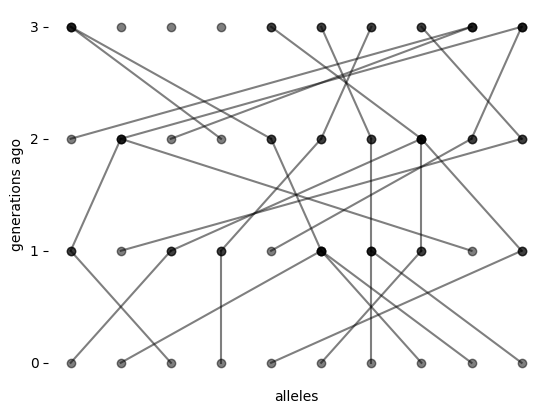

In [204]:
fig, ax = plt.subplots()

ps = simulate(N=5,tmax=4)
plot_lineages(ps,ax,alpha=0.5)

plt.show()

One of the most important aspects of this model is that we can choose to think about the history of just some subset of the alleles in the current generation. This is helpful because 1) we do not need to model the entire population and 2) this has a close connection to data (since we almost never sample every individual in a population).

To see this visually, we can choose a few "sample" alleles from the current generation and highlight their "lineages".

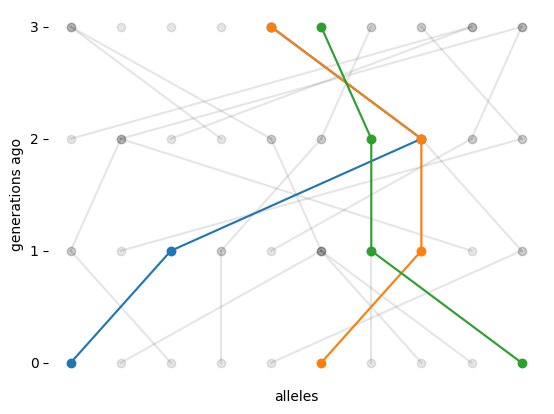

In [206]:
fig, ax = plt.subplots()

plot_lineages(ps,ax,alpha=0.1) #plot full population in background

# plot sample lineages
for i in [0,5,9]: #samples
    path = [i] #lineage of sample i
    for p in ps[1:]: #loop over generations
        path.append(p[i]) #add parent 
        i = p[i] #make parent the child
    ax.plot(path,range(len(path)), marker='o')
    
plt.show()

### Time for two lineages to coalesce

When two sample lineages meet at a **most recent common ancestor** we say they **coalesce** ("come together"). This is where the name of the model comes from, **the coalescent**. (Note that some reserve that name for the continuous-time limit of this model, but we won't be so strict.) 

The time it takes for two lineages to coalesce determines how similar those alleles are. The more distant their most recent common ancestor the more mutations that are expected to have accumulated. Thus the time to coalescence influences the amount of genetic diversity we expect to see.  

The first question we will ask with this model is: how many generations does it take for two lineages to coalesce? Let's call this random variable $T_2$. We want to know how this random variable is distributed.

Consider one generation at a time. We choose the parent of one of the alleles at random. We do the same for the second allele. The probability that the two lineages coalesce in the previous generation is the probability that the parent of the second allele is the same as the parent of the first allele, $p_2=1/(2N)$. 

Let $X=1$ if the two lineages coalesce in the previous generation, $X=0$ if they don't coalesce. Then $X$ is a Bernoulii random variable, $X\sim\text{Ber}(p_2)$. We can now rephrase our question mathematically: how many Bernoulli trials do we have to perform to get one success?

!!! note "Geometric random variable"

    Let $X$ be the number of Bernoulli trials (with success probability $p$) that it takes to get 1 success. Then the probability we need to perform $X=k$ trials is the probability of having $k-1$ failures (which happens with probability $(1-p)^{k-1}$) followed by a success (which happens with probability $p$)
    
    $$\Pr(X=k) = (1-p)^{k-1}p$$
    
    This random variable $X$ is called a "geometric random variable" with parameter $p$ and denoted $X\sim\text{Geo}(p)$. After evaluating a few infinite sums it can be shown to have expectation
    
    $$\mathbb{E}(X) = \frac{1}{p}$$
    
    and variance
    
    $$\text{Var}(X) = \frac{1-p}{p^2}$$
    
Returning to the coalescent, the time for two sample lineages to coalesce is therefore geometrically distributed, $T_2\sim\text{Geo}(p_2)$. We then can expect to wait 

$$\begin{aligned}
\mathbb{E}(T_2) 
&= 1/p_2\\
&=2N
\end{aligned}$$ 

generations until coalescence of the two lineages. However, the variance around this expectation is 

$$\begin{aligned}
\text{Var}(T_2) 
&= \frac{1-p_2}{p^2}\\
&=2N(2N-1)
\end{aligned}$$

which is roughly $(2N)^2$ in a large population, $2N>>1$. Since $N^2$ can be very large relative to $N$, this means that there is *a lot* of noise around the expectation.

We can see how noisey the coalescence time is by sampling from a geometric distribution for a given value of $N$. For example, below we sample the coalescence time 1000 times with $N=1000$ and plot those times in a histogram. We often see coalescence times ranging from very near 1 to well over 10000 (run the code a few times if you'd like).

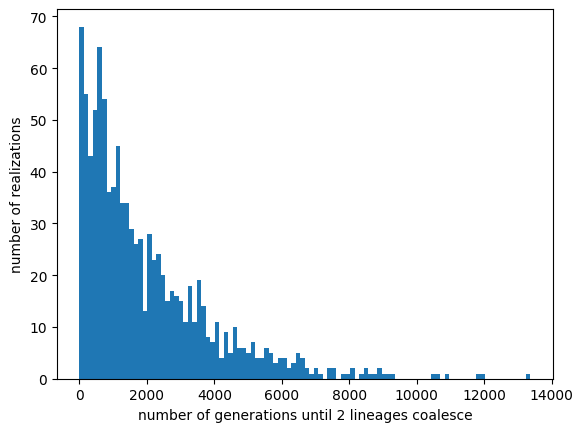

In [176]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

N = 1000 #diploid population size
p = 1/(2*N) #probability 2 lineages coalesce in the previous generation
ts = np.random.geometric(p,1000) #sample from a geometric with param p 1000 times
ax.hist(ts, bins=100) #histogram of coalescence times

ax.set_xlabel('number of generations until 2 lineages coalesce')
ax.set_ylabel('number of realizations')
plt.show()

### Time for $n$ lineages to coalesce

Considering only two samples is a special case that gives us some intuition about the model. But in general we want to know, how long until $n$ samples all share a common ancestor? Let this time be random variable $M_n$. We want to know something about $M_n$. 

We start by assuming that only one pair of lineages can coalesce each generation, which is valid when the population size is large, $N>>1$, and the sample is relatively small $n<<N$. Then we can write $M_n$ as the time it takes to go from $n$ to $n-1$ lineages, $T_n$, plus the time it takes to go from $n-1$ to $n-2$ lineages, $T_{n-1}$, and so on down to the time it takes to go from 2 to 1 lineages, $T_2$

$$M_n = T_n + T_{n-1} + ... + T_2$$

The next step is to find out something about the $T_i$. We do this by noting that when there are $i$ lineages the probability of *no* coalescence in the previous generation is

$$1-p_i = \left(1-\frac{1}{2N}\right)\left(1-\frac{2}{2N}\right)...\left(1-\frac{i-1}{2N}\right)$$

In words, we choose any parent for the first lineage, the second lineage does not have the same parent with probability $1-\frac{1}{2N}$, the third lineage does not have the same parent as either of the first two lineages with probability $1-\frac{2}{2N}$, and so on to the $i^\text{th}$ lineage.

This is a complicated expression but we can simplify by taking a Taylor series around $1/N=0$ and approximating to first order, which gives

$$\begin{aligned}
1-p_i 
&\approx 1 - \frac{1}{2N}\sum_{j=1}^{i-1}j\\
&= 1 - \frac{1}{2N}\frac{i(i-1)}{2}\\
&= 1 - \frac{{i \choose 2}}{2N}\\
\end{aligned}$$

so that the probability that there is coalescence is

$$p_i \approx \frac{{i \choose 2}}{2N}$$

This makes good sense. When $N$ is large there can be at most 1 coalescent event per generation among the sample lineages. Since there are ${i \choose 2}$ ways to choose a pair of lineages from $i$ lineages, each of which coalesce with probability $1/(2N)$, the probability of coalescence is ${i \choose 2}/(2N)$.

We can now treat the $T_i$ as geometric random variables with parameter $p_i$, $T_i\sim\text{Geo}(p_i)$.

This means that $M_n$, the time for $n$ samples to coalesce into 1, is the sum of $n-1$ independent geometric random variables. Unfortunately this doesn't produce a nice distribution (in contrast to the sum of Poisson random variables we saw in the last lecture). However, we can calculate the expectation since we know the expectation of a sum is the sum of the expectations

$$\begin{aligned}
\mathbb{E}(M_n) 
&= \mathbb{E}(T_n + T_{n-1} + ... + T_2)\\
&= \mathbb{E}(T_n) + \mathbb{E}(T_{n-1}) + ... + \mathbb{E}(T_2)\\
&= 1/p_n + 1/p_{n-1} + ... + 1/p_2\\
&\approx \frac{2N}{{n \choose 2}} + \frac{2N}{{n-1 \choose 2}} + ... + \frac{2N}{{2 \choose 2}}\\
&= 2N \sum_{i=2}^n \frac{1}{{i \choose 2}} \\
&= 4N \frac{n-1}{n} \\
\end{aligned}$$

Since $(n-1)/n<1$ we see that all $n$ sample lineages are expected to coalesce in less than $4N$ generations. This is pretty remarkable given we expect to wait more than half that time just for 2 sample lineages to coalesce! The reason for this is that coalescence happens faster when there are more lineages (since there are more pairs to choose from). So if we take a large sample then most of the lineages will coalesce very quickly and most of the time spent waiting for the most recent common ancestor will be once few lineages remain. Below we take advantage of a great Python package, ```msprime```, to quickly simulate the coalescent with $n$ samples and plot the history of those samples (a **coalescent tree**).

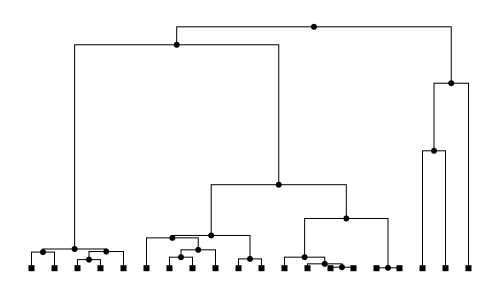

In [198]:
import msprime
n = 10
ts = msprime.sim_ancestry(n) #simulate coalescent with n samples
ts.first().draw_svg(node_labels={}, size=(500,300)) #plot tree without node labels